# Initial Setup

## Libraries

In [321]:
import warnings
import sys
import os
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

logger = logging.getLogger(__name__)
 
import pprint
import pylab
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy
from scipy import signal
from scipy.io import wavfile

from tqdm import tqdm_notebook

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler


font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [451]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Activation, Conv2D, Input, MaxPooling2D, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as kb

In [323]:
print("=== Library Versions ===")
print("SciPy:     ",scipy.__version__)
print("Numpy:     ",np.__version__)
print("TensorFlow:",tf.__version__)
print("Keras:     ",keras.__version__)

=== Library Versions ===
SciPy:      1.6.0
Numpy:      1.19.5
TensorFlow: 2.3.1
Keras:      2.4.0


## Custom Functions

In [324]:
# Error-to-Signal Ratio
def ESR(y_actual,y_predicted):
    return kb.sum(kb.square(y_actual-y_predicted),axis=0)/(kb.sum(kb.square(y_actual),axis=0)+kb.epsilon())

In [325]:
# Function: Convert some hex value into an array for C programming
# Source: Machine Learning on Microcontroller Lecture, ETH Zurich
def hex_to_c_array(hex_data, var_name):
 
    c_str = ''
 
    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'
 
    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'
 
    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :
 
        # Construct string from hex
        hex_str = format(val, '#04x')
 
        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)
 
    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'
 
    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'
 
    return c_str

In [396]:
def generate_dataset(sensor_input, sensor_out, rec_field, nr_sensors, samples=-1):
    if samples == -1 or samples < 0:
          samples = sensor_input.shape[0]-rec_field
        

    # Matrix, each column containing the previous N input samples
    X = np.empty((samples ,rec_field, nr_sensors))
    # Vector, each entry containing the current output samples
    y = np.empty((samples ,1, 1))
    
    X[:,:,:] = np.lib.stride_tricks.as_strided(
        sensor_input,
        (samples, rec_field, nr_sensors),
        (8, 8, sensor_input.shape[0]*8),
        writeable=False
    )
    y[:,0,0] = sensor_out[rec_field:rec_field+samples]

    return X, y

In [327]:
class SensorSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, rec_field, nr_sensors, shuffle=False):
        self.x, self.y = x_set, y_set
        self.rec_field = rec_field
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.nr_sensors = nr_sensors

         # Matrix, each column containing the previous N input samples
        self.batch_x = np.empty((self.batch_size ,self.rec_field,self.nr_sensors))
        # Vector, each entry containing the current output samples
        self.batch_y = np.empty((self.batch_size ,1,1))

        self.order = np.arange(0, self.__len__())

        if self.shuffle:
              self.order = np.random.randint(0,self.__len__(),self.__len__())
 
    def __len__(self):
        return np.math.floor((self.x.shape[0]-self.rec_field) / (self.batch_size))

    def __getitem__(self, idx, ):
        batch = self.order[idx]*self.batch_size

        self.batch_x[:,:,:] = np.lib.stride_tricks.as_strided(
            self.x[batch:batch+self.rec_field+self.batch_size,:],
            (self.batch_size, self.rec_field, self.nr_sensors), 
            (8, 8, self.x.shape[0]*8),
            writeable=False
        )
        self.batch_y[:,0,0] = self.y[batch+self.rec_field:batch+self.rec_field+self.batch_size]

        return np.array(self.batch_x), np.array(self.batch_y)

    def on_epoch_end(self):
        if self.shuffle:
              self.order = np.random.randint(0,self.__len__(),self.__len__())

# Configuration

In [527]:
TRAIN = True

# Neural Network
EPOCHS      = 1000
BATCH_SIZE  = 16
BATCH_SIZE_PREDICT = 16
REC_FIELD = 100

QUANTIZE = True
 
HOME_FOLDER = './'
 
# Model Description
ITERATION = 1
VERSION = 1
NAME = '2DConv'

DRONE_IDENTIFIER = 'CF_PHILIP_posz'
IGNORE_SENSORS = ['z_offset', 'zslope']

# Data
SHUFFLE       = False
 
TRAIN_TEST_SPLIT = 0.8 # Use 60% for training
TRAIN_VAL_SPLIT  = 0.8 # Use another 60% of the remaining data for training and 30% for validation
 
DATASET = 'ctrl_50ms_07'

TRAIN_SENSOR_IN  = HOME_FOLDER + 'Dataset/'+DATASET+'cf.csv'
TRAIN_SENSOR_OUT = HOME_FOLDER + 'Dataset/'+DATASET+'vicon.csv'

MODEL_NAME = '{:02d}_{}_v{:d}'.format(ITERATION,NAME,VERSION) 
MODEL_PATH = '{}{:02d}_Data/{}'.format(HOME_FOLDER, ITERATION, MODEL_NAME) 
 
print("=== File Configuration ===")
print("Model Name   :", MODEL_NAME)
print("Sensor Input :", TRAIN_SENSOR_IN)
print("Sensor Output:", TRAIN_SENSOR_OUT)
print("Model Path   :", MODEL_PATH)

=== File Configuration ===
Model Name   : 01_2DConv_v1
Sensor Input : ./Dataset/ctrl_50ms_07cf.csv
Sensor Output: ./Dataset/ctrl_50ms_07vicon.csv
Model Path   : ./01_Data/01_2DConv_v1


# Preprocessing

## Import Data

In [528]:
CF_df = pd.read_csv(TRAIN_SENSOR_IN, header=0, names=["Timestamp", "Timestamp_CF", "ID", "Value"]) # New dataformat including timestamp from crazyfly
#CF_df    = pd.read_csv(TRAIN_SENSOR_IN,  header=0, names=["Timestamp", "ID", "Value"])
VICON_df = pd.read_csv(TRAIN_SENSOR_OUT, header=0, names=["Timestamp", "ID", "Value"])

drone_t0 = CF_df["Timestamp"].iloc[0]
vicon_t0 = VICON_df["Timestamp"].iloc[0]
CF_df["Timestamp"] = CF_df["Timestamp"]-drone_t0
VICON_df["Timestamp"] = VICON_df["Timestamp"]-vicon_t0 

## Build Dataset

In [531]:
TIME_INTERVAL = '50L'

drone_z = CF_df.copy()
vicon_z = VICON_df.loc[VICON_df['ID'] == DRONE_IDENTIFIER].reset_index(drop=True)

vicon_z['Timestamp'] *= 1E6
drone_z['Timestamp'] *= 1E6

vicon_z.index = pd.DatetimeIndex(data=vicon_z['Timestamp'])
time_origin = vicon_z.index.to_pydatetime()[0]
vicon_z_res = vicon_z.drop(columns=['Timestamp', 'ID']).resample(TIME_INTERVAL, origin=time_origin).mean().interpolate()

Dataset_df = pd.DataFrame()
# extract the time-of-flight sensor value
for k, group in drone_z.groupby(["ID"]):
    if k in IGNORE_SENSORS:
        continue
    group = group.reset_index()
    group.index = pd.DatetimeIndex(data=group['Timestamp'])
    group = group.drop(columns=['Timestamp']).resample(TIME_INTERVAL, origin= time_origin).mean().interpolate()
    Dataset_df[k] = group["Value"]
NR_SENSORS = Dataset_df.shape[1]+3
    
Dataset_df['vicon.z'] = vicon_z_res["Value"]
Dataset_df['vicon.dz'] = Dataset_df['stateEstimate.z']-Dataset_df['vicon.z']
Dataset_df['vicon.ddz'] = Dataset_df['vicon.dz'].diff().fillna(0)
Dataset_df['vicon.to_high'] = (Dataset_df['vicon.dz']<-0.1).astype(int)

srate = 1.0 / (Dataset_df.index[1]-Dataset_df.index[0]).total_seconds()
Dataset_df.head()

acc.z  acc.zslope  posCtl.targetZ  range.zrange  \
Timestamp                                                                     
1970-01-01 00:00:00.000  0.999111         0.0             0.0         27.00   
1970-01-01 00:00:00.050  0.997646         0.0             0.0         28.50   
1970-01-01 00:00:00.100  0.996181         0.0             0.0         30.00   
1970-01-01 00:00:00.150  1.001213         0.0             0.4         30.50   
1970-01-01 00:00:00.200  0.987987         0.0             0.4         30.25   

                         range.zslope  stateEstimate.vz  stateEstimate.z  \
Timestamp                                                                  
1970-01-01 00:00:00.000           0.0          0.000178         0.028048   
1970-01-01 00:00:00.050           0.0          0.001981         0.028278   
1970-01-01 00:00:00.100           0.0          0.003784         0.028508   
1970-01-01 00:00:00.150           0.0          0.008151         0.029852   
1970-01-01 00:00:00.200           0.0          0.009157         0.030173   

                          vicon.z  vicon.dz  vicon.ddz  vicon.to_high  
Timestamp                                                              
1970-01-01 00:00:00.000  0.035733 -0.007685   0.000000              0  
1970-01-01 00:00:00.050  0.035700 -0.007422   0.000263              0  
1970-01-01 00:00:00.100  0.035700 -0.007191   0.000230              0  
1970-01-01 00:00:00.150  0.035711 -0.005859   0.001333              0  
1970-01-01 00:00:00.200  0.035724 -0.005552   0.000307              0

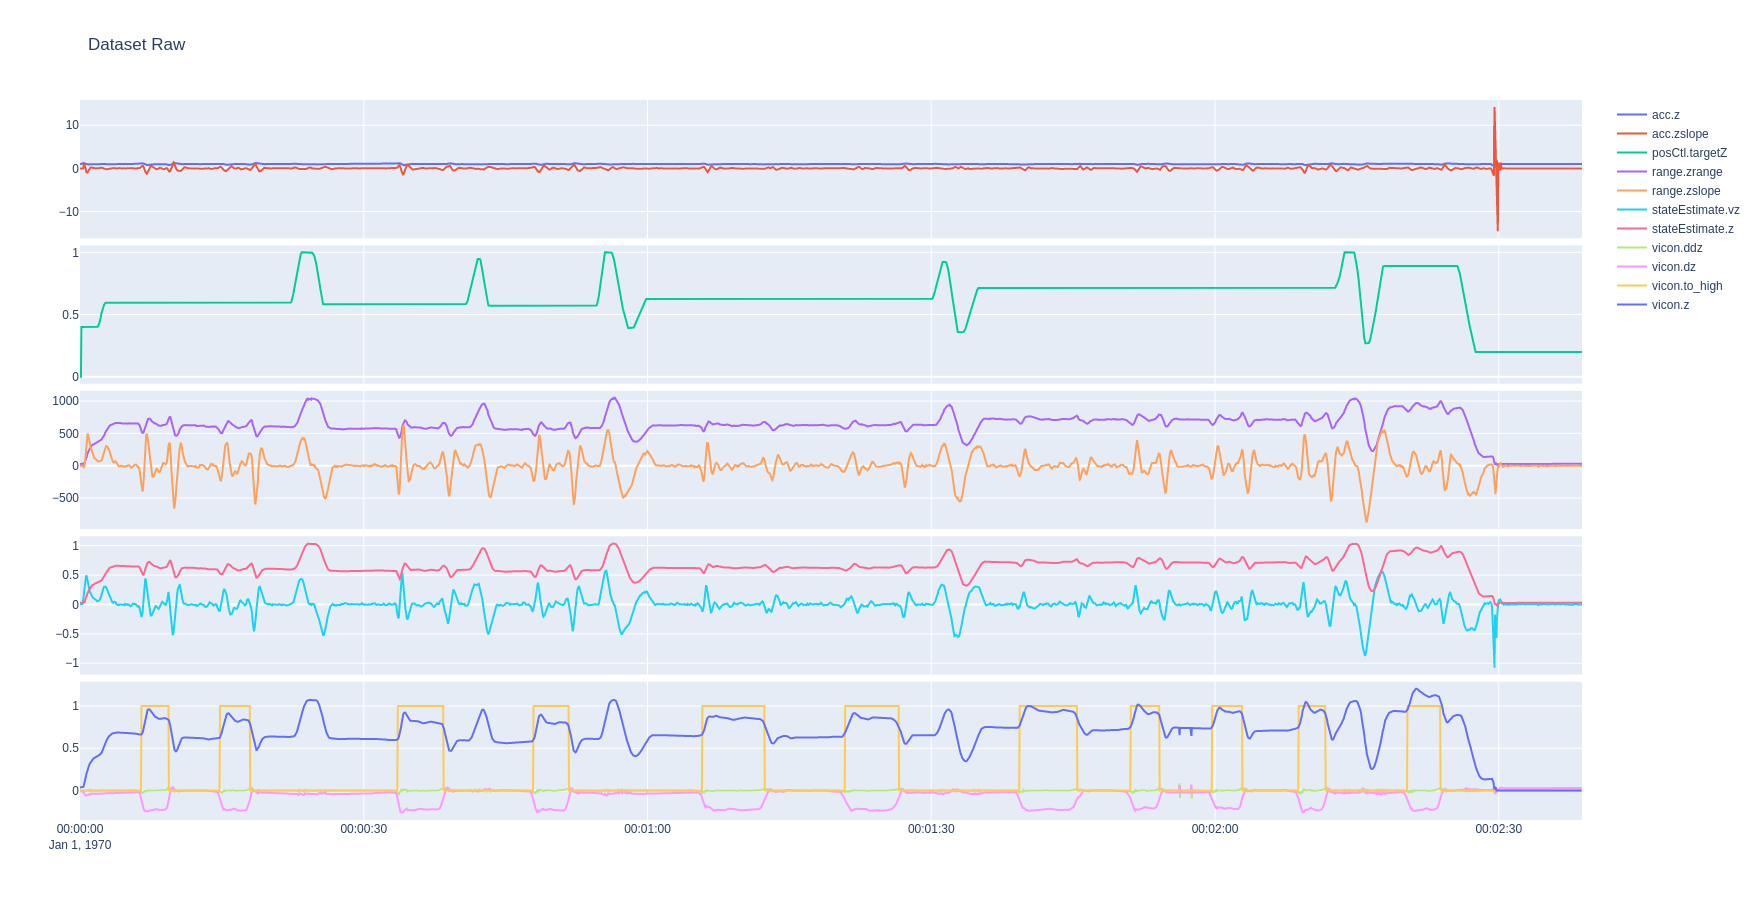

In [532]:
groups = np.unique([x.split(".")[0] for x in np.unique(Dataset_df.columns)]) 

fig = make_subplots(rows=len(groups), cols=1, shared_xaxes=True, vertical_spacing=0.01)
for k in np.sort(Dataset_df.columns):
    index = groups.tolist().index(k.split(".")[0]) + 1
    fig.append_trace(go.Scatter(x=Dataset_df[k].index, y=Dataset_df[k], mode="lines", name=k,), row = index, col = 1)              

fig.update_layout(
    title_text="Dataset Raw", 
    height=(len(groups)+1)*150, 
    width=15*80, 
    legend_tracegroupgap = 110,
)
fig.show()

In [533]:
index_test  = int(Dataset_df.shape[0]*(1-TRAIN_TEST_SPLIT))
index_val   = int(Dataset_df.shape[0]*(1-TRAIN_VAL_SPLIT)*TRAIN_TEST_SPLIT)+index_test
index_train = int(Dataset_df.shape[0]*TRAIN_VAL_SPLIT*TRAIN_TEST_SPLIT)+index_test
 
print(index_test, index_val, index_train)

test_sensor_input  = Dataset_df.iloc[0:max(index_test-REC_FIELD,0), :NR_SENSORS].to_numpy(copy=True)
val_sensor_input   = Dataset_df.iloc[index_test:max(index_val-REC_FIELD,0), :NR_SENSORS].to_numpy(copy=True)
train_sensor_input = Dataset_df.iloc[index_val:, :NR_SENSORS].to_numpy(copy=True)
 
test_sensor_out   =  Dataset_df['vicon.to_high'].iloc[0:max(index_test-REC_FIELD,0)].to_numpy(copy=True)
val_sensor_out    =  Dataset_df['vicon.to_high'].iloc[index_test:max(index_val-REC_FIELD,0)].to_numpy(copy=True)
train_sensor_out  =  Dataset_df['vicon.to_high'].iloc[index_val:].to_numpy(copy=True)

test_sensor_input_padded = np.pad(test_sensor_input, ((REC_FIELD,0), (0,0)) )
test_sensor_out_padded   = np.pad(test_sensor_out, (REC_FIELD,0) )

print("In. Sensors: {:7d} sensors".format(NR_SENSORS))
print("Test Size  : {:7d} samples, {:.2f} s".format(test_sensor_input.shape[0], test_sensor_input.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_sensor_input.shape[0], val_sensor_input.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_sensor_input.shape[0], train_sensor_input.shape[0]/srate))
print()
print("Test Size  : {:7d} samples, {:.2f} s".format(test_sensor_out.shape[0], test_sensor_out.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_sensor_out.shape[0], val_sensor_out.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_sensor_out.shape[0], train_sensor_out.shape[0]/srate))

635 1143 2668
In. Sensors:      10 sensors
Test Size  :     535 samples, 26.75 s
Val Size   :     408 samples, 20.40 s
Train Size :    2034 samples, 101.70 s

Test Size  :     535 samples, 26.75 s
Val Size   :     408 samples, 20.40 s
Train Size :    2034 samples, 101.70 s


In [534]:
scl = StandardScaler()

train_sensor_input_scl      = train_sensor_input.copy()
test_sensor_input_padded_scl = test_sensor_input_padded.copy()
val_sensor_input_scl         = val_sensor_input.copy()

if train_sensor_input.shape[0] > 0:
    train_sensor_input_scl = scl.fit_transform(train_sensor_input)
    
if test_sensor_input_padded.shape[0] > 0:
    test_sensor_input_padded_scl = scl.transform(test_sensor_input_padded)
    
if val_sensor_input.shape[0] > 0:
    val_sensor_input_scl = scl.transform(val_sensor_input)

In [535]:
seq_test  = SensorSequence(test_sensor_input_padded_scl,  test_sensor_out_padded,  BATCH_SIZE_PREDICT, REC_FIELD, NR_SENSORS)
seq_train = SensorSequence(train_sensor_input_scl, train_sensor_out, BATCH_SIZE, REC_FIELD, NR_SENSORS,  shuffle=SHUFFLE)
seq_val   = SensorSequence(val_sensor_input_scl,   val_sensor_out,   BATCH_SIZE_PREDICT, REC_FIELD, NR_SENSORS, shuffle=SHUFFLE)

In [536]:
if False:
    d = generate_dataset(train_sensor_input_scl, train_sensor_out, REC_FIELD, NR_SENSORS, BATCH_SIZE_PREDICT)
    print("RAW")
    print(train_sensor_input_scl[:BATCH_SIZE_PREDICT+REC_FIELD-1,0:3])
    print(train_sensor_input_scl[:BATCH_SIZE_PREDICT+REC_FIELD-1,].shape)
    print("RESHAPE1")
    print(d[0][:,0,:].reshape(-1, NR_SENSORS)[:,0:3])
    print(d[0][:,0,:].reshape(-1, NR_SENSORS)[:,0:3].shape)
    print("RESHAPE2")
    print(d[0][-1,:,:].reshape(-1, NR_SENSORS)[:,0:3])
    print(d[0][-1,:,:].reshape(-1, NR_SENSORS)[:,0:3].shape)

    print("Dataset")
    print(d[0].shape)
    print(d[0][:,:,0:3])

In [537]:
if False:
    d = generate_dataset(train_sensor_input_scl, train_sensor_out, REC_FIELD, NR_SENSORS, BATCH_SIZE_PREDICT)

    plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD),train_sensor_out[REC_FIELD:REC_FIELD+BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
    plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), d[1].reshape(-1), 'r--')
    plt.title("Sensor Output")
    plt.xlim([REC_FIELD,BATCH_SIZE_PREDICT+REC_FIELD-1])
    plt.grid()
    plt.show()

    plt.plot(train_sensor_input_scl[:BATCH_SIZE_PREDICT+REC_FIELD-1,:], 'b-', linewidth=2, alpha=0.6)
    plt.plot(np.arange(0, BATCH_SIZE_PREDICT), d[0][:,0,:].reshape(-1, NR_SENSORS), 'r--')
    plt.plot(np.arange(BATCH_SIZE_PREDICT-1, REC_FIELD+BATCH_SIZE_PREDICT-1), d[0][-1,:,:].reshape(-1, NR_SENSORS), 'r--')
    plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD-2])
    plt.title("Sensor Input")
    plt.grid()
    plt.show()

In [539]:
if False:
    INDEX = 26
    plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), train_sensor_out[INDEX*BATCH_SIZE_PREDICT+REC_FIELD:REC_FIELD+(1+INDEX)*BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
    plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), seq_train.__getitem__(INDEX)[1].reshape(-1), 'r--')
    plt.title("Sensor Output")
    plt.grid()
    plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD-1])
    plt.show()

    plt.plot(train_sensor_input_scl[INDEX*BATCH_SIZE_PREDICT:(1+INDEX)*BATCH_SIZE_PREDICT+REC_FIELD-1,:], 'b-', linewidth=2, alpha=0.6)
    plt.plot(np.arange(0, BATCH_SIZE_PREDICT), seq_train.__getitem__(INDEX)[0][:,0,:].reshape(-1, NR_SENSORS), 'r--')
    plt.plot(np.arange(BATCH_SIZE_PREDICT-1, REC_FIELD+BATCH_SIZE_PREDICT-1), seq_train.__getitem__(INDEX)[0][-1,:,:].reshape(-1, NR_SENSORS), 'r--')
    plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD-2])
    plt.grid()
    plt.title("Sensor Input")
    plt.show()

# Neural Network

## Definition

In [544]:
# Creating the model from the paper
model = Sequential( name = MODEL_NAME)
 
model.add( Conv1D(1, kernel_size=30, strides=1, padding='valid', activation='relu', input_shape=(REC_FIELD, NR_SENSORS)) )
#model.add( MaxPooling1D(pool_size=3) )
model.add( Conv1D(10, kernel_size=5, strides=1, padding='valid', activation='relu') )
#model.add( MaxPooling1D(pool_size=3) )
model.add( Flatten())
model.add( Dense(1, activation='relu'))
 
model = model_from_json(model.to_json())

In [545]:
# Display a summary of the model (number of layers and parameters, ect)
model.summary()

Model: "01_2DConv_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 71, 1)             301       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 67, 10)            60        
_________________________________________________________________
flatten_30 (Flatten)         (None, 670)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 671       
Total params: 1,032
Trainable params: 1,032
Non-trainable params: 0
_________________________________________________________________


In [546]:
if TRAIN:
      # Compile model (define optimization algorithm, loss function)
      #model.compile(optimizer=Adam(learning_rate=0.001),loss=ESR)
    model.compile(optimizer=Adam(learning_rate=0.001),loss=BinaryCrossentropy())

## Training

In [547]:
if TRAIN:
  # Train the network
  history = model.fit(seq_train, validation_data=seq_val, epochs = EPOCHS, max_queue_size=200)

Epoch 1/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9812 - val_loss: 5.5307
Epoch 2/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 3/1000
120/120 [==============================] - 1s 6ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 4/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 5/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 6/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 7/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 8/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 9/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.9810 - val_loss: 5.5307
Epoch 10/1000
120/120 [==============================] - 1s 5ms/step - loss: 4.981

KeyboardInterrupt: 

In [ ]:
if TRAIN:
    if not os.path.exists(os.path.dirname(MODEL_PATH + '.h5')):
        try:
            os.makedirs(os.path.dirname(MODEL_PATH + '.h5'))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

    # Save the model
    model.save(MODEL_PATH + '.h5') 

## Evaluation

dict_keys(['loss', 'val_loss'])


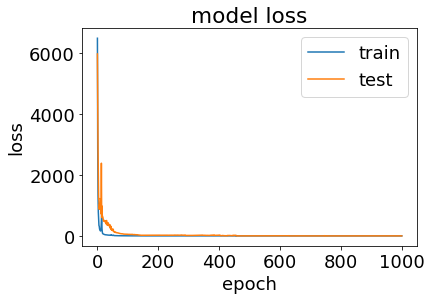

In [390]:
if TRAIN:
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [391]:
LOAD_MODEL = MODEL_PATH
 
model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')

Loading Model: ./01_Data/01_2DConv_v1.h5


In [392]:
print("Evaluate on test data")
results = model.evaluate(seq_test, workers=1, max_queue_size=20, verbose=1)
print("Test ESR: {:.2f}%".format(100*results))

Evaluate on test data
10/10 [==============================] - 0s 2ms/step - loss: 29493.7871
Test ESR: 2949378.71%


# Post Training Quantization

## Conversion

In [70]:
QUANTIZE = "int8" # "int8" or "float16" or "" (None)

LOAD_MODEL = MODEL_PATH

model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')

if (QUANTIZE == ""):
  LOAD_TFL = LOAD_MODEL + '_tfl'
else:
  LOAD_TFL = LOAD_MODEL + '_tfl_' + QUANTIZE
print("Output Model:", LOAD_TFL)

Loading Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1.h5
Output Model: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl_int8


In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model( model)

# This is very important! Otherwise TensorFlow Lite will generate models with
# operations that are not supported by TensorFlow Lite Micro such as EXPAND_DIMS.
converter.experimental_new_converter = False 

# Convert the model to the TensorFlow Lite format with quantization
if (QUANTIZE == "int8"):    
  def representative_dataset():
    dataset = generate_dataset(val_audio_input, val_audio_amp, REC_FIELD)[0]
    for i in tqdm_notebook(range(len(val_audio_input)-REC_FIELD)):
      yield([dataset[i].astype(np.float32).reshape(1,REC_FIELD,1)]) 
 
  # Set the optimization flag.
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # Enforce full-int8 quantization
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
 
  converter.target_spec.supported_types = [tf.int8]
 
  converter.inference_input_type = tf.int8  # or tf.uint8
  converter.inference_output_type = tf.int8  # or tf.uint8
 
  # Provide a representative dataset to ensure we quantize correctly.
  converter.representative_dataset = representative_dataset
elif (QUANTIZE == "float16"):
  # Set the optimization flag.
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  converter.target_spec.supported_types = [tf.float16]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpddo1c6bf/assets


INFO:tensorflow:Assets written to: /tmp/tmpddo1c6bf/assets


In [72]:
print("Save TFLite:", LOAD_TFL + '.tflite')
open(LOAD_TFL + '.tflite', 'wb').write(tflite_model)

Save TFLite: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl_int83.tflite


12320

In [78]:
tf_model = open("/content/drive/MyDrive/Colab Notebooks/00_Architecture/Dilation.tflite", 'rb')

In [79]:
print("Save model to " + LOAD_TFL + '.tflite')
# Write TFLite model to a C source (or header) file
with open("/content/drive/MyDrive/Colab Notebooks/00_Architecture/Dilation.h", 'w') as file:
    file.write(hex_to_c_array(tf_model, MODEL_NAME[3:]))

Save model to /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl_int8.tflite


TypeError: ignored

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=LOAD_TFL + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()
 
print("== Input details ==")
print("name :", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type :", input_details[0]['dtype'])
 
print("\n== Output details ==")
print("name :", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type :", output_details[0]['dtype'])

ValueError: ignored

## Evaluation

In [ ]:
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

X,y  = generate_dataset(test_audio_input, test_audio_amp_padded, REC_FIELD)
if (input_scale == 0):
  input_scale = 1.0
if (output_scale == 0):
  output_scale = 1.0

X = X / input_scale + input_zero_point
y = y / output_scale + output_zero_point

print("Input Scale :", input_scale)
print("Input Zero  :", input_zero_point)
print("Output Scale:", output_scale)
print("Output Zero :", output_zero_point)

Input Scale : 0.0032520967070013285
Input Zero  : 10
Output Scale: 0.0078125
Output Zero : 0


In [ ]:
output = np.zeros(len(test_audio_input)-REC_FIELD)

STOP  = len(output)-(REC_FIELD//2+3)
for i in tqdm_notebook(range(0,STOP)):
    tflite_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X[i], axis=0).astype(input_details[0]["dtype"]))
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()
    output[i+REC_FIELD//2+3] = (tflite_interpreter.get_tensor(output_details[0]['index'])[:,0,0]-output_zero_point)*output_scale


wavfile.write(LOAD_TFL + '.wav', srate, output)
# Convolute signal with impulse response from loudspeaker
pred_tflite_path = conv(LOAD_TFL + '.wav', IMPULSE_AUDIO)


Processing...
Output file: /content/drive/MyDrive/Colab Notebooks/04_Data/04_OrangeMicroDark_WN12_v1_tfl_int8_conv.wav
Convolution success.


In [ ]:
ipd.Audio(output, rate=srate)

In [ ]:
test_audio_input[0:44100*TEST_DURATION].astype(dtype=np.float32).tofile(HOME_FOLDER + "Datasets/OrangeMicroDark/test_audio_input.bin")
print("Saved to:", HOME_FOLDER + "Datasets/OrangeMicroDark/test_audio_input.bin")

Saved to: /content/drive/MyDrive/Colab Notebooks/Datasets/OrangeMicroDark/test_audio_input.bin


# Outputs

In [393]:
print("Loading:", LOAD_TFL + '.txt' )
mcu = np.loadtxt(LOAD_TFL + '.txt', comments="#")

print(mcu.shape)

wavfile.write(LOAD_TFL + '_mcu.wav', srate, mcu)
pred_tflite_path = conv(LOAD_TFL + '_mcu.wav', IMPULSE_AUDIO)

NameError: name 'LOAD_TFL' is not defined

In [ ]:
error = ESR(test_audio_amp_padded[REC_FIELD:REC_FIELD+44100],  [:44100])
print("Test ESR: {:.2f}%".format(100*error))